# Neural ODE control of $\dot{x}=u(t)$ without activation

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib as mpl
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 7,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 4}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 433.62 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width,fig_height]
rcParams.update({'figure.figsize': fig_size})

Define time horizon, initial condition, and target state.

In [2]:
T = 1
true_x0 = torch.tensor([0.])
t = torch.linspace(0., T, 100)
target_x = torch.tensor([-1])

Define neural ODE with control term.

In [3]:
class ODE_func(nn.Module):

    def __init__(self, eps1, eps2):
        super(ODE_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1,1)
        )

        self.net[0].weight = torch.nn.Parameter(torch.tensor([[0.0+float(eps1)]]))
        self.net[0].bias = torch.nn.Parameter(torch.tensor([-1.0+float(eps2)]))
        
    def forward(self, t, y):
        return self.net(torch.tensor([float(t)]))

SGD test (comparison with analytical GD)

In [29]:
func = ODE_func(-1, -1)
loss_arr = []
print(func.net[0].weight,func.net[0].bias)
optimizer = optim.SGD(func.parameters(), lr=1e-2)
for i in range(150):
    pred_x = odeint(func, true_x0, t, method='dopri5')
    loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
    loss.backward()
    optimizer.step()
    loss_arr.append(float(loss))
print(pred_x[-1],func.net[0].weight,func.net[0].bias)

Parameter containing:
tensor([[-1.]], requires_grad=True) Parameter containing:
tensor([-2.], requires_grad=True)
tensor([-0.2078], grad_fn=<SelectBackward>) Parameter containing:
tensor([[-0.1421]], requires_grad=True) Parameter containing:
tensor([-0.2842], requires_grad=True)


In [28]:
loss_arr_SGD_em1 = loss_arr

In [30]:
loss_arr_SGD_em2 = loss_arr

In [24]:
loss_arr_Adam_em1 = loss_arr

In [32]:
print(min(loss_arr_Adam_em1),min(loss_arr_SGD_em1),min(loss_arr_SGD_em2))

2.747738835751079e-05 1.9862103727064095e-05 0.00020079076057299972


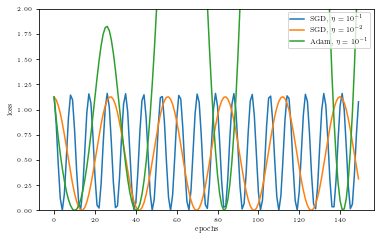

In [31]:
plt.figure()
plt.plot(loss_arr_SGD_em1,label=r"SGD, $\eta=10^{-1}$")
plt.plot(loss_arr_SGD_em2,label=r"SGD, $\eta=10^{-2}$")
plt.plot(loss_arr_Adam_em1,label=r"Adam, $\eta=10^{-1}$")
plt.ylim(0,2)
plt.xlabel(r"epochs")
plt.ylabel(r"loss")
plt.legend(loc=1)
plt.show()

In [10]:
0.5-1e-1*1/2*(1/2*0.5-1+1),-1-1e-1*(1/2*0.5-1+1)

(0.4875, -1.025)

Solve control problem.

In [11]:
eps1_arr, eps2_arr = np.linspace(-1,1,10), np.linspace(-1,1,10)

w_arr = []
b_arr = []
MSE_arr = []

samples_w = []
samples_b = []

for eps1 in eps1_arr:
    for eps2 in eps2_arr:
        
        func = ODE_func(eps1, eps2)
        MSE = -1
        weight = []
        bias = []
        
        w_traj = []
        b_traj = []
        
        optimizer = optim.Adam(func.parameters(), lr=1e-1)

        best_model = func.net
        loss_new = 1e9
        
        for itr in range(1, 100):
            
            w_traj.append(float(func.net[0].weight))
            b_traj.append(float(func.net[0].bias))

            optimizer.zero_grad()
            pred_x = odeint(func, true_x0, t, method='dopri5')
            loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
            loss.backward()
            optimizer.step()

            if loss < loss_new:
                best_model = func.net
                loss_new = loss
                weight = float(func.net[0].weight)
                bias = float(func.net[0].bias)
                MSE = 1/2*(float(func.net[0].weight)**2+(float(func.net[0].bias)+1)**2)

            if itr % 20 == 0:
                with torch.no_grad():
                    pred_x = odeint(func, true_x0, t, method='dopri5')
                    loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
                    print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                    itr += 1
            
        samples_w.append(w_traj)
        samples_b.append(b_traj)
        MSE_arr.append(MSE)
        w_arr.append(weight)
        b_arr.append(bias)

Iter 0020 | Total Loss 0.082715
Iter 0040 | Total Loss 0.011427
Iter 0060 | Total Loss 0.001351
Iter 0080 | Total Loss 0.000033
Iter 0020 | Total Loss 0.055936
Iter 0040 | Total Loss 0.004559
Iter 0060 | Total Loss 0.000001
Iter 0080 | Total Loss 0.000127
Iter 0020 | Total Loss 0.017379
Iter 0040 | Total Loss 0.000219
Iter 0060 | Total Loss 0.000704
Iter 0080 | Total Loss 0.000006
Iter 0020 | Total Loss 0.000062
Iter 0040 | Total Loss 0.003146
Iter 0060 | Total Loss 0.000126
Iter 0080 | Total Loss 0.000000
Iter 0020 | Total Loss 0.010517
Iter 0040 | Total Loss 0.000455
Iter 0060 | Total Loss 0.000056
Iter 0080 | Total Loss 0.000022
Iter 0020 | Total Loss 0.000005
Iter 0040 | Total Loss 0.000394
Iter 0060 | Total Loss 0.000024
Iter 0080 | Total Loss 0.000011
Iter 0020 | Total Loss 0.000904
Iter 0040 | Total Loss 0.000043
Iter 0060 | Total Loss 0.000017
Iter 0080 | Total Loss 0.000001
Iter 0020 | Total Loss 0.000010
Iter 0040 | Total Loss 0.000050
Iter 0060 | Total Loss 0.000007
Iter 008

Iter 0040 | Total Loss 0.000050
Iter 0060 | Total Loss 0.000007
Iter 0080 | Total Loss 0.000000
Iter 0020 | Total Loss 0.002528
Iter 0040 | Total Loss 0.000141
Iter 0060 | Total Loss 0.000020
Iter 0080 | Total Loss 0.000006
Iter 0020 | Total Loss 0.006524
Iter 0040 | Total Loss 0.000870
Iter 0060 | Total Loss 0.000023
Iter 0080 | Total Loss 0.000012
Iter 0020 | Total Loss 0.004919
Iter 0040 | Total Loss 0.000720
Iter 0060 | Total Loss 0.000266
Iter 0080 | Total Loss 0.000037
Iter 0020 | Total Loss 0.004039
Iter 0040 | Total Loss 0.002368
Iter 0060 | Total Loss 0.000161
Iter 0080 | Total Loss 0.000072
Iter 0020 | Total Loss 0.036285
Iter 0040 | Total Loss 0.000809
Iter 0060 | Total Loss 0.000415
Iter 0080 | Total Loss 0.000069
Iter 0020 | Total Loss 0.004919
Iter 0040 | Total Loss 0.000720
Iter 0060 | Total Loss 0.000266
Iter 0080 | Total Loss 0.000037
Iter 0020 | Total Loss 0.006524
Iter 0040 | Total Loss 0.000870
Iter 0060 | Total Loss 0.000023
Iter 0080 | Total Loss 0.000012
Iter 002

In [12]:
class ODE_func_diff_init(nn.Module):

    def __init__(self, weight, bias):
        super(ODE_func_diff_init, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(1,1)
        )

        self.net[0].weight = torch.nn.Parameter(torch.tensor([[float(weight)]]))
        self.net[0].bias = torch.nn.Parameter(torch.tensor([float(bias)]))
        
    def forward(self, t, y):
        return self.net(torch.tensor([float(t)]))

In [13]:
loss_analytical_arr = []
loss_nn_arr = []
ww_arr = np.arange(-2, 2.1, .1)

for i in range(len(ww_arr)):
    func = ODE_func_diff_init(ww_arr[i], -1-0.5*ww_arr[i])
    pred_x = odeint(func, true_x0, t, method='dopri5')
    loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
    loss_analytical_arr.append(float(loss))

for i in range(len(w_arr)):
    func = ODE_func_diff_init(w_arr[i], b_arr[i])
    pred_x = odeint(func, true_x0, t, method='dopri5')
    loss = 0.5*torch.abs(pred_x[-1] - target_x)**2
    loss_nn_arr.append(float(loss))

<ipython-input-20-7f4ba52e9686>:8: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(im, cax=cax, orientation='vertical', norm=mpl.colors.Normalize(vmin=0, vmax=1.2))


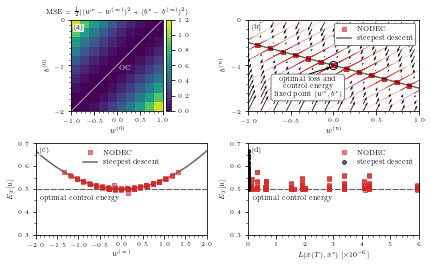

In [20]:
fig, ax = plt.subplots(ncols=2,nrows=2)
fig.patch.set_facecolor('white')

ax[0,0].set_title(r"$\mathrm{MSE}=\frac{1}{2}((w^*-w^{(\infty)})^2 + (b^*-b^{(\infty)})^2)$")
im = ax[0,0].imshow(np.flipud(np.array(MSE_arr).reshape(len(eps1_arr),len(eps1_arr)).T), extent=[-1, 1, -2, 0])
divider = make_axes_locatable(ax[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical', norm=mpl.colors.Normalize(vmin=0, vmax=1.2))
im.set_clim(0,1.2)

ax[0,0].plot(np.linspace(-1,1),np.linspace(-2,0),color="white",linewidth=0.6)
ax[0,0].text(0.05,-1.1,r"OC",color="w")

lb = ax[0,0].text(0.02*2-1,0.9*2-2,r"(a)")
lb.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

ax[0,0].set_xlabel(r"$w^{(0)}$")
ax[0,0].set_ylabel(r"$b^{(0)}$")
ax[0,0].set_xticks([-1,-0.5,0,0.5,1])
ax[0,0].set_yticks([-2,-1,0])
ax[0,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[0,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.125))

W, B = np.meshgrid(np.arange(-1, 1, .15), np.arange(-2, 0, .15))

dW = -0.5*(1+0.5*W+B)
dB = -1.0*(1+0.5*W+B)

ww = np.linspace(-4,4)

lb = ax[0,1].text(0.02*2-1,0.9*2-2,r"(b)",backgroundcolor='w')
lb.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0.1))

ax[0,1].quiver(W, B, dW, dB, units='width', edgecolor='k')

for i in range(len(eps1_arr)**2):
    ax[0,1].plot(samples_w[i],samples_b[i],linewidth=0.3,color="tab:red",alpha=0.6)

ax[0,1].plot(w_arr,b_arr,marker='s',markersize=4,alpha=0.6,color='tab:red',ls='None',label='NODEC')
ax[0,1].plot(ww,-1-0.5*ww,alpha=0.6,color='k',label=r"steepest descent")
ax[0,1].plot(0,-1,'ko',markersize=8,alpha=1,markerfacecolor='None')
legend01 = ax[0,1].legend(loc=1,frameon=True,edgecolor='Grey')
legend01.get_frame().set_alpha(None)
ax[0,1].set_xlim(-1,1)
ax[0,1].set_ylim(-2,0)
ax[0,1].set_xlabel(r"$w^{(n)}$")
ax[0,1].set_ylabel(r"$b^{(n)}$")
ax[0,1].set_xticks([-1,-0.5,0,0.5,1])
ax[0,1].set_yticks([-2,-1,0])
ax[0,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[0,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax[0,1].annotate("optimal loss and \n control energy \n fixed point $(w^*,b^*)$",ha="center",xy=(0,-2),xytext=(-0.3,-1.68)\
                 ,bbox={'facecolor': 'white', 'alpha': 1.0, 'pad': 0.4, 'boxstyle':'round', 'edgecolor':'Grey'})
ax[0,1].annotate( "", xy=(-0.01,-1.03), xytext=(-0.3,-1.2),
              arrowprops=dict( arrowstyle="->" ) )

tt = np.linspace(0,1,100)

energy_analytical_arr = []
energy_nn_arr = []

for w in ww_arr:
    energy_analytical_arr.append(np.trapz(0.5*(w*tt+(-1-0.5*w))**2,tt))
    
for i in range(len(w_arr)):
    energy_nn_arr.append(np.trapz(0.5*(w_arr[i]*tt+b_arr[i])**2,tt))

lb = ax[1,0].text(0.02*4-2,0.9*0.4+0.3,r"(c)",backgroundcolor='w')
lb.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0.1))

ax[1,0].plot(w_arr,energy_nn_arr,marker='s',color='tab:red',markersize=4,alpha=0.6,ls='None',label=r"NODEC",zorder=1)
ax[1,0].plot(ww_arr,energy_analytical_arr,alpha=0.6,color='k',label=r"steepest descent",zorder=0)
ax[1,0].plot(ww_arr,len(ww_arr)*[np.trapz(len(tt)*[0.5*1**2],tt)],ls=(0, (5, 1)),linewidth=1.2,color='k',alpha=0.6,zorder=0)
ax[1,0].text(-1.9,0.45,r"optimal control energy")

ax[1,0].set_xlabel(r"$w^{(\infty)}$")
ax[1,0].set_ylabel(r"$E_T[u]$")
ax[1,0].set_xlim(-2,2)
ax[1,0].set_ylim(0.3,0.7)
ax[1,0].set_yticks([0.3,0.4,0.5,0.6,0.7])
ax[1,0].legend(loc=9,frameon=False)
ax[1,0].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax[1,0].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

lb = ax[1,1].text(0.02*6,0.9*0.4+0.3,r"(d)",backgroundcolor='w')
lb.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0.1))

ax[1,1].plot(1e6*np.array(loss_nn_arr),energy_nn_arr,marker='s',markersize=4,alpha=0.6,color='tab:red',ls='None',label='NODEC')
ax[1,1].plot(1e6*np.array(loss_analytical_arr),energy_analytical_arr,marker='o',markersize=4,alpha=0.6,color='k',ls='None',label='steepest descent')
ax[1,1].plot(np.linspace(0,6),50*[np.trapz(len(tt)*[0.5*1**2],tt)],ls=(0, (5, 1)),linewidth=1.2,color='k',alpha=0.6,zorder=0)
ax[1,1].text(0.16,0.45,r"optimal control energy")

ax[1,1].legend(loc=1,frameon=False)
ax[1,1].set_xlabel(r"$L(x(T),x^*)$ [$\times 10^{-6}$]")
ax[1,1].set_ylabel(r"$E_T[u]$")
ax[1,1].set_xlim(0,6)
ax[1,1].set_ylim(0.3,0.7)
ax[1,1].set_yticks([0.3,0.4,0.5,0.6,0.7])
ax[1,1].xaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax[1,1].yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

plt.tight_layout()
plt.savefig("simple_dynamics.png",dpi=300)
plt.show()